# Modelowanie ARMA

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

#from ts_utils import check_time_series_stationary
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
from statsmodels.tsa.stattools import adfuller
def check_time_series_stationary(y, rolling_len = 12):
    
    y = pd.Series(y)
    
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

## Zadanie 1

Dokonaj analizy szeregu czasowego `Sunspots`. Dopasuj odpowiedni model i dokonaj predykcji.

In [3]:
print(sm.datasets.sunspots.NOTE) #inne sunspotsy (o dłuższym okresie czasowym)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



[datetime.datetime(1700, 12, 31, 0, 0), datetime.datetime(1701, 12, 31, 0, 0), datetime.datetime(1702, 12, 31, 0, 0), datetime.datetime(1703, 12, 31, 0, 0), datetime.datetime(1704, 12, 31, 0, 0), datetime.datetime(1705, 12, 31, 0, 0), datetime.datetime(1706, 12, 31, 0, 0), datetime.datetime(1707, 12, 31, 0, 0), datetime.datetime(1708, 12, 31, 0, 0), datetime.datetime(1709, 12, 31, 0, 0), datetime.datetime(1710, 12, 31, 0, 0), datetime.datetime(1711, 12, 31, 0, 0), datetime.datetime(1712, 12, 31, 0, 0), datetime.datetime(1713, 12, 31, 0, 0), datetime.datetime(1714, 12, 31, 0, 0), datetime.datetime(1715, 12, 31, 0, 0), datetime.datetime(1716, 12, 31, 0, 0), datetime.datetime(1717, 12, 31, 0, 0), datetime.datetime(1718, 12, 31, 0, 0), datetime.datetime(1719, 12, 31, 0, 0), datetime.datetime(1720, 12, 31, 0, 0), datetime.datetime(1721, 12, 31, 0, 0), datetime.datetime(1722, 12, 31, 0, 0), datetime.datetime(1723, 12, 31, 0, 0), datetime.datetime(1724, 12, 31, 0, 0), datetime.datetime(1725, 

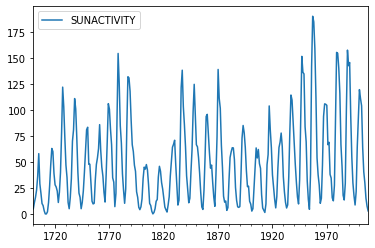

In [4]:
sunspots = sm.datasets.sunspots.load_pandas().data
print(sm.tsa.datetools.dates_from_range('1700', '2008'))
sunspots.index = pd.date_range('1700', '2008', freq='AS')
sunspots = sunspots.drop('YEAR', axis=1)

sunspots.plot() #mamy okres

In [5]:
sunspots

,SUNACTIVITY
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2
2007-01-01,7.5


Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -2.8378
p-value             :     0.0531
--------------------------------



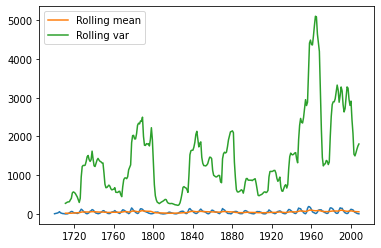

      Autocorrelation plot      
--------------------------------



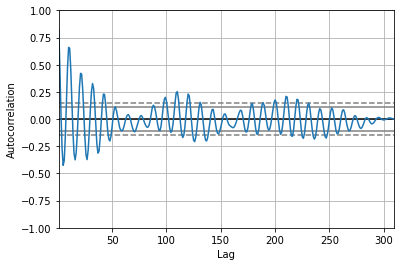

In [6]:
check_time_series_stationary(sunspots.SUNACTIVITY)

In [ ]:
# Na poziomie istotnosci 10% zakładamy, że szereg jest stacjonarny, choć tak naprawdę z wykresów acfów widać, że nie jest najlepiej

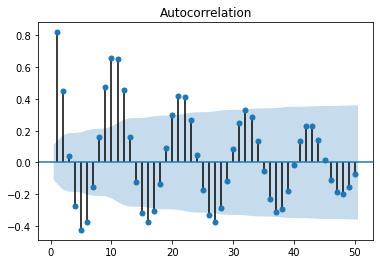

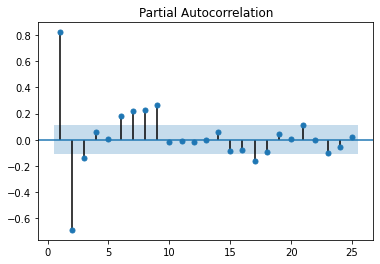

In [7]:
plot_acf(sunspots.SUNACTIVITY, lags=50, zero=False)
plt.show()

plot_pacf(sunspots.SUNACTIVITY, lags=25, zero=False)
plt.show()

# MA => ACF
# AR => PACF

In [8]:
?ARIMA
# order = (p,d,q) p - AR, d - roznicowania, q - MA

In [9]:
# może AR(2)?
ar2 = ARIMA(endog=sunspots, order=(2, 0, 0)) 
ar2 = ar2.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [10]:
ar2.summary() # Yt = a*Y_{t-1} + b*Y_{t-2} + c

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                     ARMA(2, 0)   Log Likelihood               -1307.318
Method:                       css-mle   S.D. of innovations             16.576
Date:                Sun, 11 Sep 2022   AIC                           2622.636
Time:                        15:26:46   BIC                           2637.570
Sample:                    01-01-1700   HQIC                          2628.607
                         - 01-01-2008                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                49.6595      3.165     15.689      0.000      43.456      55.863
ar.L1.SUNACTIVITY     1.3907      0.041     33.954      0.000       1.310       1.471
ar.L2.SUNACTIVITY    -0.6886      0.041    -16.803      0.000      -0.769      -0.608
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0098           -0.6577j            1.2051           -0.0919
AR.2            1.0098           +0.6577j            1.2051            0.0919
-----------------------------------------------------------------------------
"""

In [ ]:
# Y_t =  49.6594 +  1.3907 * Y_{t-1} - 0.6886 * Y_{t-2}

In [11]:
ar2.params #współczynniki AR(2)

const                49.659485
ar.L1.SUNACTIVITY     1.390656
ar.L2.SUNACTIVITY    -0.688571
dtype: float64

In [12]:
ar2.arparams #parametry części AR w ARMA

array([ 1.39065567, -0.68857112])

In [13]:
ar2.maparams #parametry części MA w ARMA

array([], dtype=float64)

In [14]:
(ar2.aic, ar2.bic) #wartość kryteriów AIC i BIC

(2622.6363380644834, 2637.5697031720742)

In [15]:
ar2.predict() # wartosci dopasowane do modelu \hat{Y}_t = 49.6594 +  1.3907 * Y_{t-1} - 0.6886 * Y_{t-2}

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


1700-01-01    49.659485
1701-01-01    12.879295
1702-01-01    26.648684
1703-01-01    29.470536
1704-01-01    35.762270
                ...    
2004-01-01    31.767698
2005-01-01    27.114837
2006-01-01    28.417593
2007-01-01    15.412875
2008-01-01    14.757964
Freq: AS-JAN, Length: 309, dtype: float64

In [16]:
ar2.resid # Y_t - \hat{T}_t #rezydua

1700-01-01   -44.659485
1701-01-01    -1.879295
1702-01-01   -10.648684
1703-01-01    -6.470536
1704-01-01     0.237730
                ...    
2004-01-01     8.632302
2005-01-01     2.685163
2006-01-01   -13.217593
2007-01-01    -7.912875
2008-01-01   -11.857964
Freq: AS-JAN, Length: 309, dtype: float64

In [17]:
ar2.forecast(steps=1)[0] # przewidziana wartość na kolejny rok (ten który następuje po ostatnim zaobserwowanym roku)

array([13.66294573])

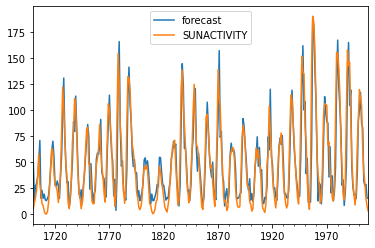

In [18]:
ar2.plot_predict(dynamic = False) #wykres wartości dopasowanych vs prawdziwe dane, w dopasowaniu za każdym razem robimy tak, że bierzemy wszystkie przeszłe dane 
#i za ich pomocą i równania modelu wyznaczamy dopasowaną wartość, przy pójściu do kolejnej obserwacji nie używamy dopasowanej wcześniej wartości z modelu, tylko prawdziwą wartość
#można to utożsamiać z procesem gdzie prognozujemy na jeden krok do przodu, a po upłynięciu czasu mamy już prawdziwą wartość w danym momencie i to jej używamy 
#do prognozy na kolejny okres
plt.show()

### Dopasowanie modelu

Diagnostyka modelu sprowadza się m.in do:
- analizy reszt - jeśli dopadowany model poprawnie wyjaśnia dynamikę czasową analizowanego zjawiska, w szeregu reszt nie powinno być widać żadnych regularnych zachowań (trendu, sezonowości), ani istotnej korelacji czasowej (dla żadnego z opóźnień), stąd:
    - w praktyce możemy posługiwać się regułą, że reszty dopasowanego modelu powinny zachowywać się w przybliżeniu jak biały szum,
    - często weryfikujemy również dodatkowo, czy rozkład reszt można uznawać za rozkład normalny
    
W praktyce sprawdzamy najczęściej 
- wykres reszt - na wykresie nie powinno być widocznych regularnych wzorów ani niejednorodności wariancji, 
- test Durbina-Watsona - niezależność błędów obserwacji, dobrze dopasowany model zakłada, że otrzymywane reszty są niezależne od siebie, innymi słowy, rozkład ich jest losowy, przypadkowy, bez stale występującego wzorca. 
- ACF/PACF dla reszt - na wykresach nie powinno być widocznych istotnych korelacji (tzw. *graficzny test białoszumowości*),
- weryfikacja normalności rozkładu reszt - wykorzystujemy narzędzia graficzne (np. Q-Q plot lub histogram) oraz formalne testy statystyczne normalności (np. test Shapiro-Wilka).

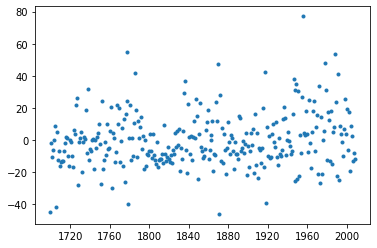

In [19]:
plt.plot(ar2.resid, '.') # powinny ukladac sie losowo wokół y = 0, wygląda ok
plt.show()

### Test Durbina-Watsona

Statystyka DW mieści się w przedziale od 0 do 4:
- w przypadku DW > 2, zakłada się występowanie autokorelacji ujemnej, 
- w przypadku DW < 2 autokorelacji dodatniej,
- wartości zbliżone do 2 oznaczają brak występowania autokorelacji. 

In [20]:
sm.stats.durbin_watson(ar2.resid) # zakładmy, że reszty nie sa skorelowane

2.145826743376785

### Wykres reszt za pomocą ACF i PACF

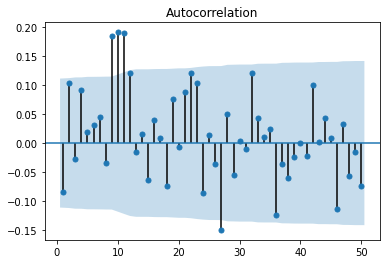

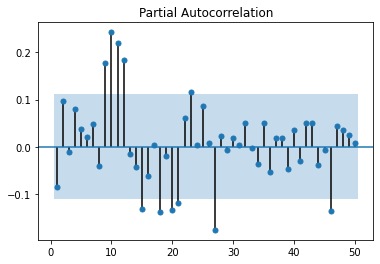

In [21]:
plot_acf(ar2.resid, lags=50, zero=False)
plt.show()

plot_pacf(ar2.resid, lags=50, zero=False)
plt.show()
#jeśli chodzi o acfy są takie które wystają takie koło 10, może nie być biały szum

### Weryfikacja normalności rozkładu reszt

1. Test Shapiro-Wilka

    H0: Rozkład badanej cechy jest rozkładem normalnym.

    H1: Rozkład badanej cechy nie jest rozkładem normalnym.
    

2. Wykres $Q-Q$

In [22]:
# test shapiro-wilka
stats.shapiro(ar2.resid)[1] #pwartosc
# pvalue < 0.05 => odrzucamy H0 => reszty nie maja rozkladu normalnego

2.46109635781977e-07

In [23]:
# test omnimbusa
stats.normaltest(ar2.resid)
# pvalue < 0.05 => odrzucamy H0 => reszty nie maja rozkladu normalnego

NormaltestResult(statistic=41.73600317165766, pvalue=8.652509064227601e-10)

In [24]:
# wykres Q-Q

from statsmodels.graphics.api import qqplot

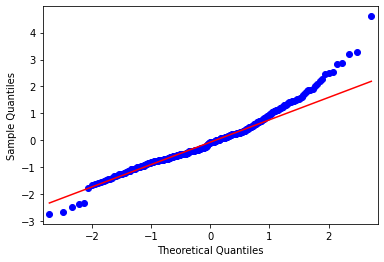

In [25]:
qqplot(ar2.resid, line='q', fit=True)
plt.show() #ogony nie są normalne

In [ ]:
# wniosek: brak dostatecznego dopasowania modelu (bo acfy nienajlepsze, dodatkowo brak normalności)

### Analiza istotności współczynników w modelu

Jakość dopasowania modelu można niekiedy poprawić eliminując te współczynniki, które są statystycznie nieistotne, to znaczy nie odgrywają istotnej roli w wyjaśnianiu dynamiki czasowej modelowanego zjawiska.

Formalnie, sprawdzamy hipotezę zerową postaci 
$$H_0: \phi_i = 0,$$
kontra hipotezie alternatywnej 
$$H_1: \phi_i \neq 0$$.

Odrzucenie $H_0$ przemawia za pozostawieniem współczynnika $\phi_i$ w modelu.

In [26]:
ar2.summary() #wszystkie istotne

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                     ARMA(2, 0)   Log Likelihood               -1307.318
Method:                       css-mle   S.D. of innovations             16.576
Date:                Sun, 11 Sep 2022   AIC                           2622.636
Time:                        15:27:34   BIC                           2637.570
Sample:                    01-01-1700   HQIC                          2628.607
                         - 01-01-2008                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                49.6595      3.165     15.689      0.000      43.456      55.863
ar.L1.SUNACTIVITY     1.3907      0.041     33.954      0.000       1.310       1.471
ar.L2.SUNACTIVITY    -0.6886      0.041    -16.803      0.000      -0.769      -0.608
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0098           -0.6577j            1.2051           -0.0919
AR.2            1.0098           +0.6577j            1.2051            0.0919
-----------------------------------------------------------------------------
"""

### Dopasowanie (Predykcja) na podstawie modelu

In [27]:
?ar2.predict

# dynamic : bool, optional
#     The `dynamic` keyword affects in-sample prediction. 
#     If dynamic is False, then the in-sample lagged values are used for
#     prediction. 
    
#     If `dynamic` is True, then in-sample forecasts are
#     used in place of lagged dependent variables. The first forecasted
#     value is `start`.

In [28]:
predict_sunspots_dynamic = ar2.predict(start='1900', end='2012', dynamic=True) #dynamic true daje nam po prostu przewidywania modelu poczynając od jakiegoś punktu startowego
#dynamic false, robi nam prognozę na podstawie wszystkich danych wartości szeregu, które indeks czasowy mają wcześniej

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


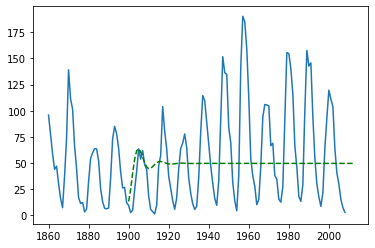

In [29]:
plt.plot(sunspots.loc['1860':])
plt.plot(predict_sunspots_dynamic, 'g--')
plt.show() #dokładamy dopasowanie, widzimy, że model nie uwzględnia sezonowości
# trzeba byłoby użyć modelu sarima

## Zadanie 2
Dla danych

1. `southern`

2. `daily-total-female-births`

dopasuj odpowiedni model $\text{AR}(p)$ lub $\text{MA}(q)$ lub $\text{ARMA}(p, q)$ (rząd $p$ i $q$ wyznacz na podstawie wykresów ACF i PACF). Sprawdź dopasowanie modeli.

In [31]:
daily_biths = pd.read_csv('daily-total-female-births.csv', 
                 parse_dates=['Date'], index_col='Date')

daily_biths.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [32]:
daily_biths.index

DatetimeIndex(['1959-01-01', '1959-01-02', '1959-01-03', '1959-01-04',
               '1959-01-05', '1959-01-06', '1959-01-07', '1959-01-08',
               '1959-01-09', '1959-01-10',
               ...
               '1959-12-22', '1959-12-23', '1959-12-24', '1959-12-25',
               '1959-12-26', '1959-12-27', '1959-12-28', '1959-12-29',
               '1959-12-30', '1959-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -4.8083
p-value             :     0.0001
--------------------------------



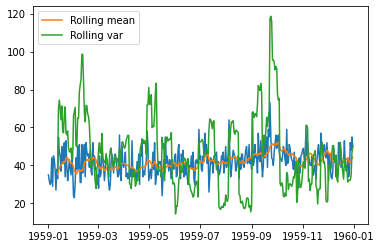

      Autocorrelation plot      
--------------------------------



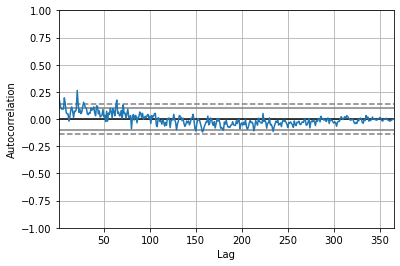

In [33]:
check_time_series_stationary(daily_biths.Births) #całkiem stacjonarny

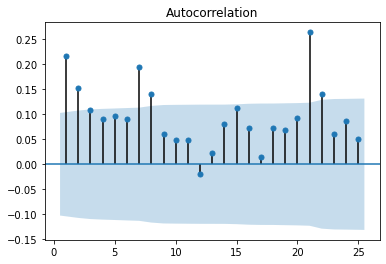

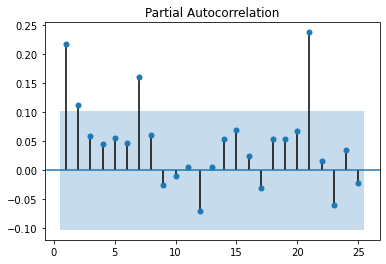

In [34]:
plot_acf(daily_biths, lags=25, zero=False)
plt.show()

plot_pacf(daily_biths, lags=25, zero=False)
plt.show()
#PACFY sugerują AR(7)

In [35]:
ar7 = ARIMA(daily_biths, order=(7, 0, 0)).fit()
ar7.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                  365
Model:                     ARMA(7, 0)   Log Likelihood               -1227.389
Method:                       css-mle   S.D. of innovations              6.982
Date:                Sun, 11 Sep 2022   AIC                           2472.778
Time:                        15:28:29   BIC                           2507.877
Sample:                    01-01-1959   HQIC                          2486.727
                         - 12-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.9580      0.788     53.257      0.000      40.414      43.502
ar.L1.Births     0.1708      0.052      3.309      0.001       0.070       0.272
ar.L2.Births     0.0853      0.053      1.624      0.104      -0.018       0.188
ar.L3.Births     0.0390      0.053      0.741      0.459      -0.064       0.142
ar.L4.Births     0.0293      0.053      0.554      0.579      -0.074       0.133
ar.L5.Births     0.0347      0.053      0.655      0.512      -0.069       0.138
ar.L6.Births     0.0211      0.053      0.397      0.692      -0.083       0.125
ar.L7.Births     0.1614      0.052      3.081      0.002       0.059       0.264
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1582           -0.0000j            1.1582           -0.0000
AR.2            0.8283           -1.0059j            1.3030           -0.1404
AR.3            0.8283           +1.0059j            1.3030            0.1404
AR.4           -1.1920           -0.5821j            1.3265           -0.4277
AR.5           -1.1920           +0.5821j            1.3265            0.4277
AR.6           -0.2807           -1.3084j            1.3382           -0.2836
AR.7           -0.2807           +1.3084j            1.3382            0.2836
-----------------------------------------------------------------------------
"""

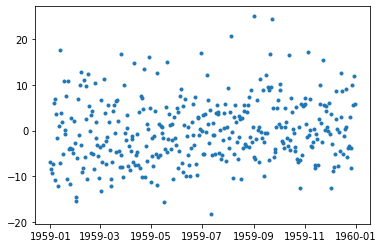

In [36]:
plt.plot(ar7.resid, '.')
plt.show() #wygląda ok

In [37]:
stats.shapiro(ar7.resid) #nie ma normalności

ShapiroResult(statistic=0.9862608313560486, pvalue=0.0015479330904781818)

In [38]:
stats.normaltest(ar7.resid)#nie ma normalności

NormaltestResult(statistic=15.040655584974154, pvalue=0.0005419548879858494)

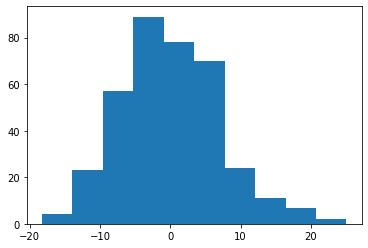

In [39]:
plt.hist(ar7.resid)
plt.show() #trochę skośny

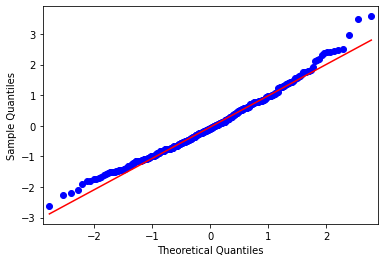

In [40]:
qqplot(ar7.resid, line='q', fit=True)
plt.show() #końcówki za mocno odbiegają

In [41]:
sm.stats.durbin_watson(ar7.resid) # zakladmy, ze reszty nie sa skorelowane

2.0144812426464664

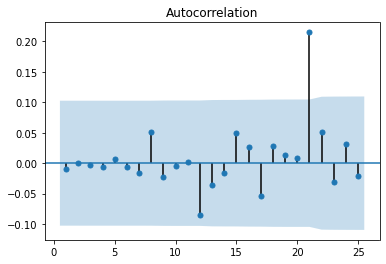

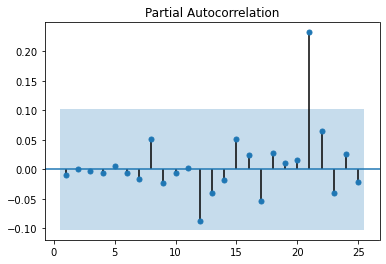

19.1049731745428

In [42]:
plot_acf(ar7.resid, lags=25, zero=False)
plt.show()

plot_pacf(ar7.resid, lags=25, zero=False)
plt.show()
#z grubsa biały szum
np.sqrt(len(ar7.resid)) #bo patrzymy na pierwsze 20 autokorelacji (sqrt(n))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


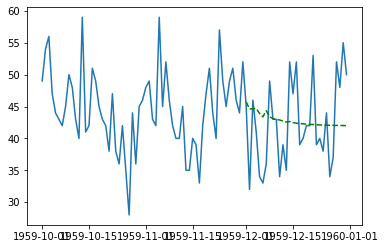

In [43]:
predict_births_dynamic = ar7.predict(start='1959-12-01', end='1959-12-31', dynamic=True)

plt.plot(daily_biths.loc['1959-10-01':])
plt.plot(predict_births_dynamic, 'g--')
plt.show() #dopasowanie mniej więcej ok

# Kryteria informacyjne oceniają jakość dopasowania modelu

Kryteria informacyjne oceniają jakość dopasowania modelu na podstawie danych historycznych, kontrolując jednocześnie stopień złożoności modelu. 

Zwiększając liczbę parametrów modelu (zwiększając złożoność modelu), możemy zazwyczaj otrzymać lepsze dopasowanie modelu do danych. Zbyt dobre dopasowanie modelu może jednak powodować problemy, a w szczególności może prowadzić do złych prognoz. Z tego powodu w postaci kryteriów wyboru modelu występuje składnik kary za wymiar modelu, w ogólności:

$$C(\text{model}) = -2 \ln(L) + \text{kara(liczba współczynników modelu)},$$
gdzie $L$ oznacza funkcję wiarogodności.

**AIC (Akaike Information Criterium)**
$$AIC(p, q) = -2 \ln(L) + 2\cdot(p+q+1)$$

**BIC (Bayesian Information Criterium)**
$$BIC(p, q) = -2 \ln(L) + (p+q+1)\cdot\ln n$$

### Kryteria oceniające dokładność prognoz 

- MSE - Mean Squared Error
- MAE - Median Absolute Error

Należy jednak pamiętać, że w odróżnieniu od kryteriów infromacyjnych, kryteria oparte na błędach predykcji nie mają wbudowanego mechanizmu, który "karałby" za złożoność modelu.

## Zadanie 3

Napisz funkcję, która dla dowolnego szeregu czasowego i modelu `ARMA` sprawdzi jego dopasowanie oraz jakość predykcji na podstawie MSE i MAE.
Zawrzyj informację o wartości oszacowanych współczynników modelu, wartości AIC i BIC, wartości statystyki Durbina-Watsona oraz ocenę normalności reszt.

Następnie sprawdź dopasowanie dla kilku wybranych modeli ARMA.

In [ ]:
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [ ]:
def fit_ARMA(ts, p, q, pred_start, pred_end):
    arma = ARIMA(ts, order=(p, 0, q)).fit()
    
    print('AR params %s' % arma.arparams)
    print('MA params %s' % arma.maparams)
    
    print('AIC: %.2f, \nBIC: %.2f' % (arma.aic, arma.bic))
    
    dw_test = sm.stats.durbin_watson(arma.resid)
    print("Statystyka Durbina-Watsona {}".format(dw_test))
    
    normal_test = stats.shapiro(arma.resid)
    print("Pvalue testu Shapiro-Wilka: {}".format(normal_test[1]))
    
    pred = arma.predict(start=pred_start, end=pred_end,dynamic = True)
        
    mse_val = mse(ts.values, pred.values)
    mae_val = mae(ts.values, pred.values)
    print('MSE: {}'.format(mse_val))
    print('MAE: {}'.format(mae_val))
    
    plt.plot(ts)
    plt.plot(pred, 'g--')
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


AR params [ 1.3906557  -0.68857116]
MA params []
AIC: 2622.64, 
BIC: 2637.57
Statystyka Durbina-Watsona 2.145826904831452
Pvalue testu Shapiro-Wilka: 2.46109635781977e-07
MSE: 1654.4026913518044
MAE: 30.665083055677584


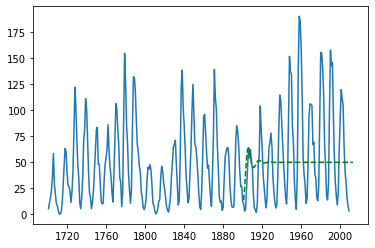

In [ ]:
fit_ARMA(sunspots, 2, 0, '1900','2012')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


AR params [ 1.47073838 -0.75512084]
MA params [-0.15369109]
AIC: 2620.28, 
BIC: 2638.94
Statystyka Durbina-Watsona 1.990341260293552
Pvalue testu Shapiro-Wilka: 3.127989245399476e-08
MSE: 1656.0623358030175
MAE: 30.658891979156227


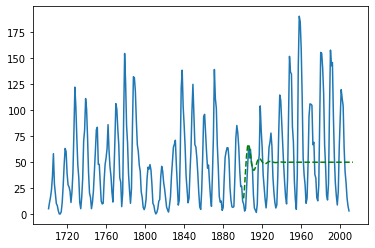

In [ ]:
fit_ARMA(sunspots, 2, 1, '1900','2012')

# Optymalna wartość $p$ na podstawie kryterium oceniającego dobroć dopasowania modelu (AIC lub BIC)

## Zadanie 4
Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepszy rząd $p$ modelu $\text{AR}(p)$ na podstawie kryterium AIC i BIC.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def find_the_best_parametr_ar(ts, max_p = 10):
    aic = np.zeros(max_p)
    bic = np.zeros(max_p)
    for i in range(1, max_p + 1):
        ar = ARIMA(ts, (i, 0, 0)).fit()
        aic[i-1] = ar.aic
        bic[i-1] = ar.bic
        
    plt.plot(range(1, max_p + 1), aic, 'r.-', label="AIC")
    plt.plot(range(1, max_p + 1), bic, 'g.-', label="BIC")
    plt.legend()
    plt.show()
        
    print("Najlepszy rząd p: {} dla kryterium AIC (AIC={})".format(np.argmin(aic) + 1, np.min(aic)))
    print("Najlepszy rząd p: {} dla kryterium BIC (BIC={})".format(np.argmin(bic) + 1, np.min(bic)))

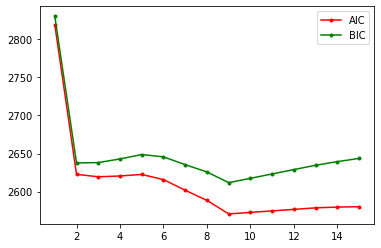

Najlepszy rząd p: 9 dla kryterium AIC (AIC=2570.622611889179)
Najlepszy rząd p: 9 dla kryterium BIC (BIC=2611.6893659350544)


In [ ]:
find_the_best_parametr_ar(sunspots, 15) #robimy wykres gdzie zobaczymy, który AR najlepiej działa (ma najmniejsze AIC lub BIC)

AR params [ 1.16071083 -0.39538204 -0.16634105  0.15044649 -0.09439243  0.00906251
  0.05205323 -0.08584366  0.25239197]
MA params []
AIC: 2570.62, 
BIC: 2611.69
Statystyka Durbina-Watsona 1.9657155253714502
Pvalue testu Shapiro-Wilka: 1.3029394949626294e-06
MSE: 1729.8561006149273
MAE: 29.244700160582873


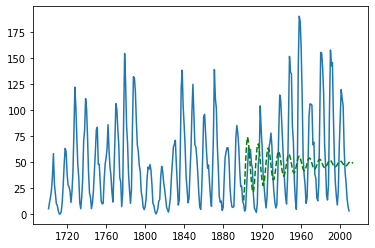

In [ ]:
fit_ARMA(sunspots, 9, 0, '1900', '2012') #dopasowanie nieco lepsze

## Zadanie 5

Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepszy rząd $p$ i $q$ modelu $\text{ARMA}(p)$ na podstawie kryterium AIC i BIC.

In [ ]:
def find_the_best_arma(ts, max_p = 10, max_q=10):
    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            arma = ARIMA(ts, order=(i + 1, 0, j + 1)).fit()
            aic[i, j] = arma.aic
            bic[i, j] = arma.bic
            print('ARMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))

In [ ]:
find_the_best_arma(sunspots, 5, 5)

ARMA(1, 1): AIC=2713.226344, BIC=2728.159709
ARMA(1, 2): AIC=2662.370188, BIC=2681.036895
ARMA(1, 3): AIC=2655.644443, BIC=2678.044491
ARMA(1, 4): AIC=2679.399246, BIC=2705.532635
ARMA(1, 5): AIC=2654.559826, BIC=2684.426556
ARMA(2, 1): AIC=2620.277192, BIC=2638.943898
ARMA(2, 2): AIC=2620.872696, BIC=2643.272743
ARMA(2, 3): AIC=2622.851691, BIC=2648.985080
ARMA(2, 4): AIC=2604.759238, BIC=2634.625968
ARMA(2, 5): AIC=2602.315832, BIC=2635.915903
ARMA(3, 1): AIC=2619.195399, BIC=2641.595447
ARMA(3, 2): AIC=2581.572299, BIC=2607.705688
ARMA(3, 3): AIC=2575.695645, BIC=2605.562375
ARMA(3, 4): AIC=2576.087553, BIC=2609.687625
ARMA(3, 5): AIC=2573.362242, BIC=2610.695654
ARMA(4, 1): AIC=2603.372560, BIC=2629.505949
ARMA(4, 2): AIC=2575.377592, BIC=2605.244322
ARMA(4, 3): AIC=2577.226195, BIC=2610.826267
ARMA(4, 4): AIC=2575.914016, BIC=2613.247428
ARMA(4, 5): AIC=2575.340422, BIC=2616.407176
ARMA(5, 1): AIC=2601.380871, BIC=2631.247601
ARMA(5, 2): AIC=2577.005621, BIC=2610.605693
ARMA(5, 3)

AR params [ 2.57124753 -2.48666735  0.89474213]
MA params [-1.42007296  0.44615551  0.0314477   0.24439556 -0.14558106]
AIC: 2573.36, 
BIC: 2610.70
Statystyka Durbina-Watsona 1.9687023376306472
Pvalue testu Shapiro-Wilka: 4.455478403997404e-07
MSE: 1739.684764251296
MAE: 29.464989412046336


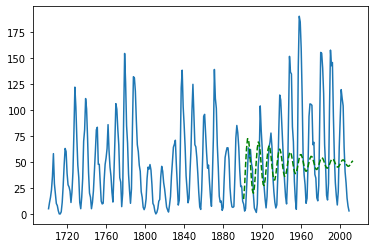

In [ ]:
fit_ARMA(sunspots, 3, 5, '1900', '2012') #dla AIC (AIC wybier modele większe lub równe BIC)

AR params [ 2.78976864 -3.06783354  1.47709754 -0.2201155 ]
MA params [-1.64805274  0.79072289]
AIC: 2575.38, 
BIC: 2605.24
Statystyka Durbina-Watsona 1.95447975503054
Pvalue testu Shapiro-Wilka: 8.849206096783746e-07
MSE: 1703.9674070745045
MAE: 29.776656984340363


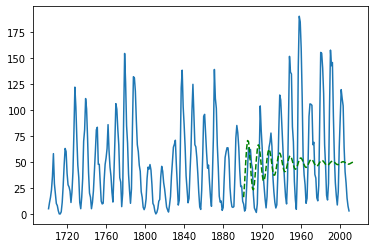

In [ ]:
fit_ARMA(sunspots, 4, 2, '1900', '2012')